In [1]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import sys
from time import time
import json
import os
import platform
import random
import requests
import pandas as pd
import numpy

from PIL import Image
from flyai.processor.base import Base
from flyai.processor.download import check_download
from flyai.utils.yaml_helper import Yaml
from flyai.utils import read_data

from path import DATA_PATH

In [2]:
from processor import load_data

In [3]:
trn, _ = load_data()

{'id': 'HandDetectionFlyAI', 'type': 'csv', 'config': {'train_url': 'https://dataset.flyai.com/dataset/HandDetectionFlyAI/dev.zip', 'test_url': 'https://dataset.flyai.com/dataset/HandDetectionFlyAI/dev.zip'}}
[200.0, 532.72, 77.72869709289354, 400.0, 533.0, 533.0, 534.0, 712.0]
[200.0, 400.0, 0.0, 400.0, 400.0, 400.0, 400.0, 400.0]
[200.0, 115.47, 106.97216610692729, 0.0, 8.0, 94.0, 214.0, 342.0]
[200.0, 74.76, 39.65963734290638, 0.0, 50.0, 75.0, 103.0, 164.0]
[200.0, 503.71, 85.16933118719653, 353.0, 465.75, 506.0, 521.25, 711.0]
[200.0, 359.81, 33.028294554912016, 278.0, 334.0, 368.0, 384.0, 399.0]
[200.0, 271.08, 88.91164153247873, 131.0, 210.0, 258.0, 318.0, 495.0]
[200.0, 84.23, 39.886737887379084, 0.0, 59.5, 90.5, 111.0, 176.0]
[200.0, 503.67, 85.1650546448678, 353.0, 465.75, 506.0, 521.0, 711.0]
[200.0, 279.51, 29.02693083272565, 218.0, 263.75, 280.0, 300.25, 345.0]
[200.0, 147.81, 112.02599258687857, 0.0, 50.0, 125.0, 248.0, 388.0]
[200.0, 224.19, 32.987494204157834, 136.0, 199

In [4]:
from __future__ import print_function
import argparse

import os
import sys
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.optim import Adam
from torch.autograd import Variable

#from flyai.dataset import Dataset
from flyai.source.base import DATA_PATH

from model import Model
from path import MODEL_PATH
from processor import DatasetFlyAI,load_data
from utils import Bunch
from vgg import VGG

    
def pretrained_net(net,class_num):
    if net=='densenet121':
        cnn = torchvision.models.densenet121(pretrained=True)
        for param in cnn.parameters():
            param.requires_grad = False
        num_features = cnn.classifier.in_features
        cnn.classifier = nn.Sequential(nn.Linear(num_features, class_num),nn.Sigmoid())
    elif net=='resnet34':
        cnn = torchvision.models.resnet34(pretrained=True)
        for param in cnn.parameters():
            param.requires_grad = False
        num_features = cnn.fc.in_features
        cnn.fc = nn.Sequential(nn.Linear(num_features, class_num),nn.Sigmoid())
    return cnn

def score(p,y):
    _,yp = torch.max(p.data,1)
    return (yp == y).sum().item()/len(y)


    
def eval(model, x_test, y_test):
    net.eval()
    batch_eval = model.batch_iter(x_test, y_test)
    total_acc = 0.0
    data_len = len(x_test)
    for x_batch, y_batch in batch_eval:
        batch_len = len(x_batch)
        outputs = net(x_batch)
        _, prediction = torch.max(outputs.data, 1)
        correct = (prediction == y_batch).sum().item()
        acc = correct / batch_len
        total_acc += acc * batch_len
    return total_acc / data_len
       


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("-e", "--EPOCHS", default=15, type=int, help="train epochs")
    parser.add_argument("-b", "--BATCH", default=64, type=int, help="batch size")
    args = parser.parse_args([])
    #dataset = Dataset(epochs=args.EPOCHS, batch=args.BATCH)
    #model = Model(dataset)
  
    #settings
    settings = {
    'net':'VGG11',
    'sigmoid':True,
    'nc':24,    
    'lr': 0.01,
    'seed': 1,
    'log_interval': 100,
    'save_model': True,
    'predict': True}
    print("1.settings",settings)
    settings = Bunch(settings)
    use_cuda = torch.cuda.is_available()
    torch.manual_seed(settings.seed)
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
    
    #load data
    trn,val = load_data()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    train_transforms= transforms.Compose([
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])
    val_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
    train_dataset = DatasetFlyAI(root=DATA_PATH,df=trn,transform=train_transforms)
    val_dataset = DatasetFlyAI(root=DATA_PATH,df=val,transform=val_transforms)
    train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=args.BATCH, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(val_dataset,
        batch_size=args.BATCH, shuffle=True, **kwargs)
    n_train = len(train_dataset)
    batch_train = n_train/args.BATCH
    print(args.BATCH,n_train/args.BATCH)
    n_test = len(val_dataset)
    batch_test = n_test/args.BATCH
    print("2. load data. train_dataset %d,batch %d, val_dataset %d, batch %d." % (n_train,batch_train,n_test,batch_test))
    

1.settings {'net': 'VGG11', 'sigmoid': True, 'nc': 24, 'lr': 0.01, 'seed': 1, 'log_interval': 100, 'save_model': True, 'predict': True}
{'id': 'HandDetectionFlyAI', 'type': 'csv', 'config': {'train_url': 'https://dataset.flyai.com/dataset/HandDetectionFlyAI/dev.zip', 'test_url': 'https://dataset.flyai.com/dataset/HandDetectionFlyAI/dev.zip'}}
[200.0, 532.72, 77.72869709289354, 400.0, 533.0, 533.0, 534.0, 712.0]
[200.0, 400.0, 0.0, 400.0, 400.0, 400.0, 400.0, 400.0]
[200.0, 115.47, 106.97216610692729, 0.0, 8.0, 94.0, 214.0, 342.0]
[200.0, 74.76, 39.65963734290638, 0.0, 50.0, 75.0, 103.0, 164.0]
[200.0, 503.71, 85.16933118719653, 353.0, 465.75, 506.0, 521.25, 711.0]
[200.0, 359.81, 33.028294554912016, 278.0, 334.0, 368.0, 384.0, 399.0]
[200.0, 271.08, 88.91164153247873, 131.0, 210.0, 258.0, 318.0, 495.0]
[200.0, 84.23, 39.886737887379084, 0.0, 59.5, 90.5, 111.0, 176.0]
[200.0, 503.67, 85.1650546448678, 353.0, 465.75, 506.0, 521.0, 711.0]
[200.0, 279.51, 29.02693083272565, 218.0, 263.75, 

In [6]:
x,y = next(iter(train_loader))

In [8]:
x.shape,y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 24]))

In [9]:
temp = [train_dataset[i] for i in range(5)]

In [11]:
temp

[(tensor([[[-0.5596, -0.5253, -0.4226,  ..., -1.0904, -1.0904, -1.1247],
           [-0.4739, -0.4568, -0.4226,  ..., -1.0733, -1.1075, -1.1247],
           [-0.4739, -0.4226, -0.3883,  ..., -1.0219, -1.0733, -1.0733],
           ...,
           [-0.4054, -0.3541, -0.3541,  ..., -1.2617, -1.2788, -1.2445],
           [-0.4739, -0.4054, -0.4054,  ..., -1.2959, -1.3130, -1.2617],
           [-0.5253, -0.4911, -0.4226,  ..., -1.3130, -1.2788, -1.3302]],
  
          [[-0.4251, -0.3901, -0.2850,  ..., -1.0028, -1.0028, -1.0378],
           [-0.3375, -0.3200, -0.2850,  ..., -0.9853, -1.0203, -1.0378],
           [-0.3375, -0.2850, -0.2500,  ..., -0.9328, -0.9853, -0.9853],
           ...,
           [-0.2675, -0.2150, -0.2150,  ..., -1.1779, -1.1954, -1.1429],
           [-0.3375, -0.2675, -0.2675,  ..., -1.2129, -1.1954, -1.1604],
           [-0.3901, -0.3550, -0.2850,  ..., -1.2304, -1.1604, -1.2129]],
  
          [[-0.2881, -0.2532, -0.1487,  ..., -0.8458, -0.8458, -0.8807],
           

In [10]:
type(temp)

list

In [12]:
from matplotlib import pyplot as plt

(array([ 4., 14.,  4., 18., 16.,  8., 22., 34., 34., 46.]),
 array([0.695  , 0.72525, 0.7555 , 0.78575, 0.816  , 0.84625, 0.8765 ,
        0.90675, 0.937  , 0.96725, 0.9975 ]),
 <a list of 10 Patch objects>)

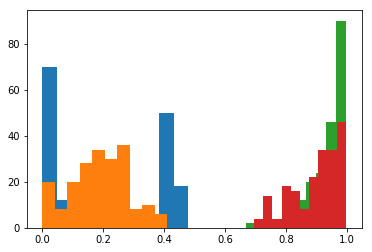

In [18]:
plt.hist(trn.p3/trn.p1)
plt.hist(trn.p4/trn.p2)
plt.hist(trn.p5/trn.p1)
plt.hist(trn.p6/trn.p2)

(array([14., 10., 16., 30., 40., 26., 32., 12., 14.,  6.]),
 array([0.545  , 0.57675, 0.6085 , 0.64025, 0.672  , 0.70375, 0.7355 ,
        0.76725, 0.799  , 0.83075, 0.8625 ]),
 <a list of 10 Patch objects>)

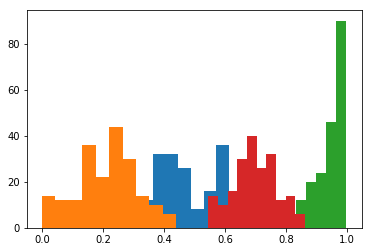

In [19]:
plt.hist(trn.p7/trn.p1)
plt.hist(trn.p8/trn.p2)
plt.hist(trn.p9/trn.p1)
plt.hist(trn.p10/trn.p2)

In [22]:
import numpy as np

(array([ 6., 16.,  6., 16., 30., 34., 46., 28., 12.,  6.]),
 array([0.4675, 0.503 , 0.5385, 0.574 , 0.6095, 0.645 , 0.6805, 0.716 ,
        0.7515, 0.787 , 0.8225]),
 <a list of 10 Patch objects>)

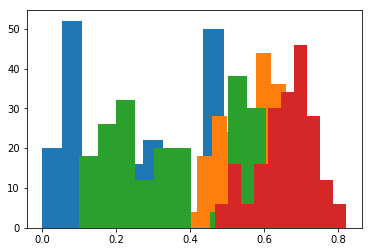

In [20]:
plt.hist(trn.p11/trn.p1)
plt.hist(trn.p12/trn.p2)
plt.hist(trn.p13/trn.p1)
plt.hist(trn.p14/trn.p2)

(array([ 4., 10., 32., 32., 26., 16., 60., 14.,  0.,  6.]),
 array([0.3425, 0.382 , 0.4215, 0.461 , 0.5005, 0.54  , 0.5795, 0.619 ,
        0.6585, 0.698 , 0.7375]),
 <a list of 10 Patch objects>)

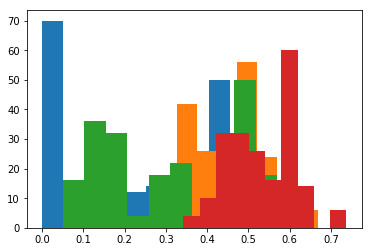

In [21]:
plt.hist(trn.p15/trn.p1)
plt.hist(trn.p16/trn.p2)
plt.hist(trn.p17/trn.p1)
plt.hist(trn.p18/trn.p2)

In [8]:
numpy.concatenate([numpy.array([1,3]),numpy.array([1,2,3])])

array([1, 3, 1, 2, 3])

In [6]:
for i in range(100):
    image_path = val.iloc[i,0]
    path = check_download(image_path, DATA_PATH)
    image = Image.open(path)
    print(image.size)

(400, 533)
(400, 533)
(400, 533)
(400, 533)
(400, 533)
(400, 533)
(400, 533)
(400, 534)
(400, 533)
(400, 533)
(400, 400)
(400, 533)
(400, 534)
(400, 712)
(400, 400)
(400, 533)
(400, 533)
(400, 533)
(400, 548)
(400, 533)
(400, 401)
(400, 533)
(400, 533)
(400, 533)
(400, 400)
(400, 512)
(400, 400)
(400, 400)
(400, 533)
(400, 542)
(400, 512)
(400, 533)
(400, 533)
(400, 533)
(400, 533)
(400, 533)
(400, 533)
(400, 712)
(400, 542)
(400, 534)
(400, 712)
(400, 533)
(400, 533)
(400, 533)
(400, 534)
(400, 542)
(400, 533)
(400, 533)
(400, 400)
(400, 512)
(400, 682)
(400, 548)
(400, 533)
(400, 548)
(400, 534)
(400, 712)
(400, 400)
(400, 533)
(400, 712)
(400, 534)
(400, 533)
(400, 400)
(400, 533)
(400, 533)
(400, 400)
(400, 533)
(400, 400)
(400, 400)
(400, 400)
(400, 712)
(400, 542)
(400, 533)
(400, 542)
(400, 533)
(400, 533)
(400, 682)
(400, 548)
(400, 400)
(400, 534)
(400, 712)
(400, 533)
(400, 534)
(400, 542)
(400, 533)
(400, 533)
(400, 712)
(400, 533)
(400, 533)
(400, 534)
(400, 533)
(400, 533)